In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, csr_matrix


%matplotlib inline

In [12]:
tops = pd.read_csv(r"clean_teapot.csv", index_col=[0]) #read in the top data
tops.MD.describe() #quick QC

count    6675.000000
mean     1676.768962
std      1396.112569
min         0.000000
25%       423.140000
50%      1456.090000
75%      2725.185000
max      6848.080000
Name: MD, dtype: float64

In [13]:
tops.SS = tops.SS - tops.SS.min() #standardize the subsea values

In [14]:
tops.head()

,API,Formation,MD,SS
45,490251022100,F2WC,2626.64,4051.44
46,490251022100,F1WCbase,2237.94,4440.14
47,490251022100,B1,2446.59,4231.49
48,490251022100,F1WC,2210.40,4467.68
49,490251040300,SHNNu,389.69,6434.39


In [15]:
#data = np.asarray(tops[["API", "Formation", "SS"]])
tops["SS"].max()

6889.86

In [16]:
D_df = tops.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land

In [17]:
D_df

API,490250632500,490250632700,490250632800,490250632900,490250633200,490250633400,490250633800,490250633900,490250634000,490250634100,...,490252284701,490252303100,490252304000,490252304700,490252304800,490252305400,490252305500,490252319500,490252345102,490252347904
Formation,,,,,,,,,,,,,,,,,,,,,
A Sand,0.00,0.00,0.00,0.00,0.00,0.00,1460.34,0.00,0.00,0.00,...,1456.19,1447.200,1478.90,1104.010,1412.240,1342.460,0.00,1308.050,0.00,0.00
ALCV,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,2380.120,2418.73,2064.860,2318.920,2270.240,0.00,2289.680,0.00,0.00
AMSD,0.00,0.00,0.00,0.00,0.00,0.00,1303.85,0.00,0.00,0.00,...,0.00,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.00,0.00
B Dolo,0.00,0.00,0.00,0.00,0.00,0.00,1433.56,0.00,0.00,0.00,...,1428.53,1419.780,1452.09,1075.880,1385.100,1316.820,0.00,1281.030,0.00,0.00
B Sand,0.00,0.00,0.00,0.00,0.00,0.00,1412.82,0.00,0.00,0.00,...,1414.49,1399.080,1432.37,1056.830,1364.740,1296.250,0.00,1261.020,0.00,0.00
B1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,4173.51,3858.830,3976.160,4044.620,0.00,4088.680,0.00,0.00
C1 Dolo,0.00,0.00,0.00,0.00,0.00,0.00,1349.52,0.00,0.00,0.00,...,1355.85,1338.120,1372.46,997.140,1313.860,1236.010,0.00,1200.000,0.00,0.00
C1 Sand,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.00,0.000,0.000,0.000,0.00,1198.000,0.00,0.00
C2 Dolo,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.00,0.000,0.000,0.000,0.00,1190.990,0.00,0.00


In [18]:
R = D_df.values
well_depth_mean = np.mean(R, axis=1) #mean depth in each well
R_demeaned = R - well_depth_mean.reshape(-1, 1)

In [19]:
from sklearn.preprocessing import binarize

A = binarize(R) 

In [20]:
#ALS factorization from 
# https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
# here items are the formation and users are the well
def runALS(A, R, n_factors, n_iterations, lambda_):
    """
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    """
    print("Initiating ")
    lambda_ = lambda_
    n_factors = 20
    n, m = A.shape
    n_iterations = n_iterations
    Users = 5 * np.random.rand(n, n_factors)
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MSE_List = []

    print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(
                np.dot(Items, np.dot(np.diag(Ri), Items.T))
                + lambda_ * np.eye(n_factors),
                np.dot(Items, np.dot(np.diag(Ri), A[i].T)),
            ).T
        print(
            "Error after solving for User Matrix:",
            get_error(A, Users, Items, R),
        )

        for j, Rj in enumerate(R.T):
            Items[:, j] = np.linalg.solve(
                np.dot(Users.T, np.dot(np.diag(Rj), Users))
                + lambda_ * np.eye(n_factors),
                np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])),
            )
        print(
            "Error after solving for Item Matrix:",
            get_error(A, Users, Items, R),
        )

        MSE_List.append(get_error(A, Users, Items, R))
        print("%sth iteration is complete..." % iter)
    return Users, Items
    # print(MSE_List)
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    # plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    # plt.savefig('Python MSE Graph.pdf', format='pdf')
    # plt.show()

In [11]:
U, Vt = runALS(R, A, 10, 5, 0.1)

Initiating 
Starting Iterations
Error after solving for User Matrix: 2987411.7776258453
Error after solving for Item Matrix: 0.000397266709219072
0th iteration is complete...
Error after solving for User Matrix: 49.1573464819213
Error after solving for Item Matrix: 0.00013143533872058167
1th iteration is complete...
Error after solving for User Matrix: 16.46708333081554
Error after solving for Item Matrix: 0.00010784661607540466
2th iteration is complete...
Error after solving for User Matrix: 10.13189642595157
Error after solving for Item Matrix: 9.899720037943771e-05
3th iteration is complete...
Error after solving for User Matrix: 7.636031691181476
Error after solving for Item Matrix: 9.686310245348374e-05
4th iteration is complete...


In [12]:
recommendations = np.dot(U, Vt) #get the recommendations

In [13]:
recsys = pd.DataFrame(
    data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
) #results

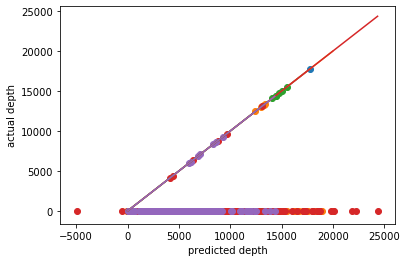

In [14]:
for i in range(5):
    plt.scatter(recsys.iloc[0:, i].values, D_df.iloc[0:, i].values) #plot predicted vs actual
    plt.xlabel('predicted depth')
    plt.ylabel('actual depth')
    plt.plot(np.arange(0,recsys.iloc[0:,i].max()))

In [15]:
recsys.iloc[0:, 1] #Predicted depths for one well

Formation
1ST JOHAH             6551.517575
1ST LANCE SS          4430.276806
1ST LOWER LANCE SS    4401.982006
1ST MIDDLE LANCE      6834.786149
1ST OVERPRESSURE      8424.268024
                         ...     
YELLOWPOINT           7654.961687
YELLOWPOINT LANCE     6682.009399
YELLOWPOINT TOP       9025.336695
YELOW POINT           3038.778193
YELOWPOINT            3464.119833
Name: 1308023, Length: 435, dtype: float64

In [16]:
D_df.iloc[0:, 1] #Actual depths for the same well

Formation
1ST JOHAH             0.0
1ST LANCE SS          0.0
1ST LOWER LANCE SS    0.0
1ST MIDDLE LANCE      0.0
1ST OVERPRESSURE      0.0
                     ... 
YELLOWPOINT           0.0
YELLOWPOINT LANCE     0.0
YELLOWPOINT TOP       0.0
YELOW POINT           0.0
YELOWPOINT            0.0
Name: 1308023, Length: 435, dtype: float64